In [1]:
from tensorflow import keras
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = '1'

In [13]:
generator = keras.Sequential()
generator.add(keras.Input(shape=(100,)))
generator.add(keras.layers.Dense(7*7*128, activation=keras.layers.LeakyReLU(0.2)))
generator.add(keras.layers.BatchNormalization())
generator.add(keras.layers.Reshape((7, 7, 128)))
generator.add(keras.layers.UpSampling2D())
generator.add(keras.layers.Conv2D(64, kernel_size=5, padding='same'))
generator.add(keras.layers.BatchNormalization())
generator.add(keras.layers.Activation(keras.layers.LeakyReLU(0.2)))
generator.add(keras.layers.UpSampling2D())
generator.add(keras.layers.Conv2D(1, kernel_size=5, padding='same', activation='tanh'))

In [14]:
generator.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 6272)              633472    
                                                                 
 batch_normalization_2 (Batc  (None, 6272)             25088     
 hNormalization)                                                 
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_4 (UpSampling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 64)        204864    
                                                                 
 batch_normalization_3 (Batc  (None, 14, 14, 64)      

In [15]:
discriminator = keras.Sequential()
discriminator.add(keras.Input(shape=(28, 28, 1)))
discriminator.add(keras.layers.Conv2D(64, kernel_size=5, strides=2, padding='same'))
discriminator.add(keras.layers.Activation(keras.layers.LeakyReLU(0.2)))
discriminator.add(keras.layers.Dropout(0.3))
discriminator.add(keras.layers.Conv2D(128, kernel_size=5, strides=2, padding='same'))
discriminator.add(keras.layers.Activation(keras.layers.LeakyReLU(0.2)))
discriminator.add(keras.layers.Dropout(0.3))
discriminator.add(keras.layers.Flatten())
discriminator.add(keras.layers.Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.trainable = False #판별자는 진품 가품 구별 학습을 따로 받아야함 -> 그래서 False를 받음

In [16]:
discriminator.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 activation_5 (Activation)   (None, 14, 14, 64)        0         
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 activation_6 (Activation)   (None, 7, 7, 128)         0         
                                                                 
 dropout_3 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten_1 (Flatten)         (None, 6272)             

In [17]:
ginput = keras.layers.Input(shape=(100,))
dis_output = discriminator(generator(ginput))
gan = keras.models.Model(ginput, dis_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential_4 (Sequential)   (None, 28, 28, 1)         865281    
                                                                 
 sequential_5 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


In [11]:
import os
if not os.path.exists('data/gan_images'):
    os.makedirs('data/gan_images')
    
def gan_train(epoch, batch_size, saving_interval):

  # MNIST 데이터를 불러옵니다.

  (X_train, _), (_, _) = mnist.load_data()  # 앞서 불러온 적 있는 MNIST를 다시 이용합니다. 단, 테스트 과정은 필요 없고 이미지만 사용할 것이기 때문에 X_train만 불러왔습니다.
  X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype(float)
  X_train = (X_train - 127.5) / 127.5  
    # 픽셀 값은 0에서 255 사이의 값입니다. 이전에 255로 나누어 줄때는 이를 0~1 사이의 값으로 바꾸었던 것인데, 
    # 여기서는 127.5를 빼준 뒤 127.5로 나누어 줌으로 인해 -1에서 1사이의 값으로 바뀌게 됩니다.
  # X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

  true = np.ones((batch_size, 1))
  fake = np.zeros((batch_size, 1))

  for i in range(epoch):
          # 실제 데이터를 판별자에 입력하는 부분입니다.
          idx = np.random.randint(0, X_train.shape[0], batch_size)
          imgs = X_train[idx]
          d_loss_real = discriminator.train_on_batch(imgs, true)

          # 가상 이미지를 판별자에 입력하는 부분입니다.
          noise = np.random.normal(0, 1, (batch_size, 100))
          gen_imgs = generator.predict(noise)
          d_loss_fake = discriminator.train_on_batch(gen_imgs, fake) #'가짜다'라고 판별하게 하는

          # 판별자와 생성자의 오차를 계산합니다.
          d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
          g_loss = gan.train_on_batch(noise, true)

          print('epoch:%d' % i, ' d_loss:%.4f' % d_loss, ' g_loss:%.4f' % g_loss)

        # 이 부분은 중간 과정을 이미지로 저장해 주는 부분입니다. 본 장의 주요 내용과 관련이 없어
        # 소스 코드만 첨부합니다. 만들어진 이미지들은 gan_images 폴더에 저장됩니다.
          if i % saving_interval == 0:
              #r, c = 5, 5
              noise = np.random.normal(0, 1, (25, 100))
              gen_imgs = generator.predict(noise)

              # Rescale images 0 - 1
              gen_imgs = 0.5 * gen_imgs + 0.5

              fig, axs = plt.subplots(5, 5)
              count = 0
              for j in range(5):
                  for k in range(5):
                      axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                      axs[j, k].axis('off')
                      count += 1
              fig.savefig("data/gan_images/gan_mnist_%d.png" % i)

1/1 [==============================] - 0s 179ms/step
epoch:0  d_loss:0.7207  g_loss:0.4237
1/1 [==============================] - 0s 40ms/step
epoch:1  d_loss:0.5562  g_loss:0.1691
1/1 [==============================] - 0s 38ms/step
epoch:2  d_loss:0.5706  g_loss:0.1287
1/1 [==============================] - 0s 38ms/step
epoch:3  d_loss:0.5494  g_loss:0.2124
1/1 [==============================] - 0s 40ms/step
epoch:4  d_loss:0.4826  g_loss:0.4030
1/1 [==============================] - 0s 37ms/step
epoch:5  d_loss:0.4322  g_loss:0.6518
1/1 [==============================] - 0s 38ms/step
epoch:6  d_loss:0.4299  g_loss:0.8754
1/1 [==============================] - 0s 40ms/step
epoch:7  d_loss:0.4671  g_loss:0.9588
1/1 [==============================] - 0s 47ms/step
epoch:8  d_loss:0.6173  g_loss:0.8048
1/1 [==============================] - 0s 47ms/step
epoch:9  d_loss:0.8466  g_loss:0.5950
1/1 [==============================] - 0s 44ms/step
epoch:10  d_loss:0.7886  g_loss:0.5823
1/1 [===

KeyboardInterrupt: 

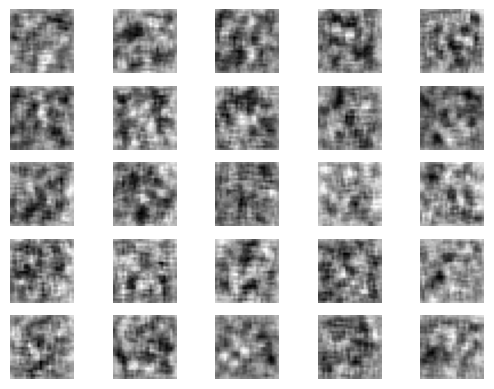

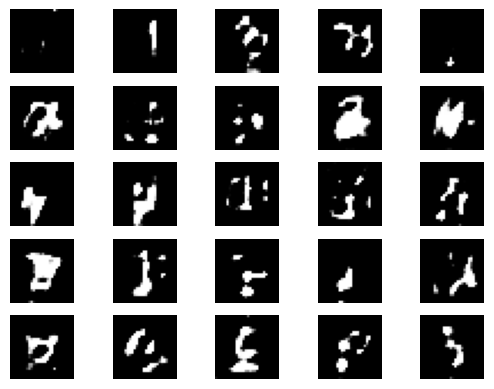

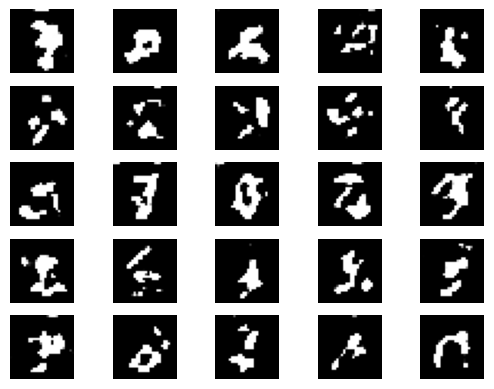

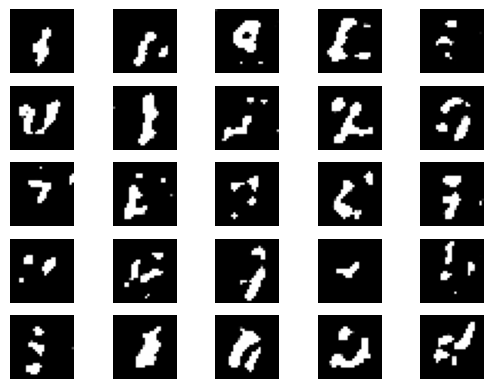

In [12]:
gan_train(2001, 32, 200)